## Top 20 Most Destructive California Wildfires

In this project, I used Geopandas to plot geospatial data. I read the __[shape file](https://data.ca.gov/dataset/ca-geographic-boundaries)__ to plot the countries on the world map and also prepared the csv file using data from __[CalFire](https://www.fire.ca.gov/media/5511/top20_destruction.pdf)__ containing details like the name and cause of the fire, county name, date, acres burnt down etc. 

GeoJSON is a popular open standard for representing geographical features with JSON. It describes points, lines and polygons (called Patches in Bokeh) as a collection of features. Each feature can also have a set of properties. Converting the geopandas file with the geometry information into a Json format is required before using Bokeh to plot data. Bokeh converts the GeoJSON coordinates into columns called x and y or xs and ys for plotting.

### Reading Data

In [524]:
#Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import json
from bokeh.io import show
from bokeh.models import (ColorBar, GeoJSONDataSource, HoverTool, LogColorMapper, NumeralTickFormatter)
from bokeh.palettes import brewer
from bokeh.plotting import figure

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#### Read the Shapefile
Geopandas can read almost any vector-based spatial data format by using the fiona library and returns a GeoDataFrame object. Any arguments passed to read_file() after the file name will be passed directly to fiona.open, which does the actual data importation.

In [525]:
#Read the world map shape file
CA_counties = gpd.read_file("CA_Counties_TIGER2016.shp")

In [526]:
CA_counties.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,06,091,00277310,06091,Sierra,Sierra County,06,H1,G4020,None,None,None,A,2468694587,23299110,+39.5769252,-120.5219926,"POLYGON ((-13431319.751 4821511.426, -13431312..."
1,06,067,00277298,06067,Sacramento,Sacramento County,06,H1,G4020,472,40900,None,A,2499183617,76073827,+38.4500114,-121.3404409,"POLYGON ((-13490651.476 4680831.603, -13490511..."
2,06,083,00277306,06083,Santa Barbara,Santa Barbara County,06,H1,G4020,None,42200,None,A,7084000598,2729814515,+34.5370572,-120.0399729,"MULTIPOLYGON (((-13423116.772 4042044.149, -13..."
3,06,009,01675885,06009,Calaveras,Calaveras County,06,H1,G4020,None,None,None,A,2641820834,43806026,+38.1838996,-120.5614415,"POLYGON ((-13428575.483 4627725.228, -13428534..."
4,06,111,00277320,06111,Ventura,Ventura County,06,H1,G4020,348,37100,None,A,4773390489,945942791,+34.3587415,-119.1331432,"MULTIPOLYGON (((-13317853.594 3931602.414, -13..."


Geopandas provides a high-level interface to the matplotlib library for making maps. Mapping shapes is as easy as using the plot() method on a GeoDataFrame.

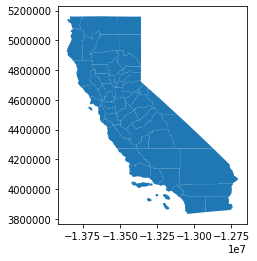

In [527]:
CA_counties.plot()

A GeoDataFrame may also contain other columns with geometrical (shapely) objects, but only one column can be the active geometry at a time. Geometries are stored in a column called geometry that is a default column name for storing geometric information in geopandas. Geopandas takes advantage of Shapely’s geometric objects. 
Our shapefile - ne_50m_admin_0_countries.shp contains a column named 'geometry. Currently, it is the active geometry column with country borders which Geopandas will use while plotting. 
We can see a world map with country boundaries marked.

#### Read the csv File

In [528]:
#Read data about the wildfires
CA_wildfires = pd.read_csv("CA_Wildfires.csv")

In [529]:
CA_wildfires.head()

,Cause,Date,County,Acres
0,CAMP FIRE (Powerlines),18-Nov,Butte County,153336
1,TUBBS (Electrical),17-Oct,Sonoma County,36807
2,TUBBS (Electrical),17-Oct,Napa County,36807
3,TUNNEL - Oakland Hills (Rekindle),Oct-91,Alameda County,1600
4,CEDAR (Human Related),3-Oct,San Diego County,273246


### Join tables
There are two ways to combine datasets in geopandas – attribute joins and spatial joins.
In an attribute join, a GeoSeries or GeoDataFrame is combined with a regular pandas Series or DataFrame based on a common variable. This is analogous to normal merging or joining in pandas.
In a Spatial Join, observations from to GeoSeries or GeoDataFrames are combined based on their spatial relationship to one another.

We will use the attribute join for CA_counties and CA_wildfires tables on keys 'NAMELSAD' and 'County' respectively.
Attribute joins are accomplished using the merge method. It is recommended to use the merge method called from the spatial dataset - CA_counties in our case. We will use a left join so that we can see all the counties, with or without wildfire.

In [530]:
CA_wildfires_counties = CA_counties.merge(CA_wildfires, left_on = 'NAMELSAD', right_on = 'County', how = "left")

In [531]:
CA_wildfires_counties.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,Cause,Date,County,Acres
0,06,091,00277310,06091,Sierra,Sierra County,06,H1,G4020,None,None,None,A,2468694587,23299110,+39.5769252,-120.5219926,"POLYGON ((-13431319.751 4821511.426, -13431312...",NaN,NaN,NaN,NaN
1,06,067,00277298,06067,Sacramento,Sacramento County,06,H1,G4020,472,40900,None,A,2499183617,76073827,+38.4500114,-121.3404409,"POLYGON ((-13490651.476 4680831.603, -13490511...",NaN,NaN,NaN,NaN
2,06,083,00277306,06083,Santa Barbara,Santa Barbara County,06,H1,G4020,None,42200,None,A,7084000598,2729814515,+34.5370572,-120.0399729,"MULTIPOLYGON (((-13423116.772 4042044.149, -13...",THOMAS (Powerline),17-Dec,Santa Barbara County,281893.0
3,06,083,00277306,06083,Santa Barbara,Santa Barbara County,06,H1,G4020,None,42200,None,A,7084000598,2729814515,+34.5370572,-120.0399729,"MULTIPOLYGON (((-13423116.772 4042044.149, -13...",PAINT (Arson),Jun-90,Santa Barbara County,4900.0
4,06,009,01675885,06009,Calaveras,Calaveras County,06,H1,G4020,None,None,None,A,2641820834,43806026,+38.1838996,-120.5614415,"POLYGON ((-13428575.483 4627725.228, -13428534...",BUTTE (Powerlines),15-Sep,Calaveras County,70868.0


In [532]:
#Replace null values in acres with 0 for counties with no fire
CA_wildfires_counties["Acres"].fillna(0, inplace=True)

In [533]:
#Replace null values in Cause and Date with blank for counties with no fire
CA_wildfires_counties["Cause"].fillna('', inplace=True)
CA_wildfires_counties["Date"].fillna('', inplace=True)

In [534]:
#Check data
CA_wildfires_counties.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,Cause,Date,County,Acres
0,06,091,00277310,06091,Sierra,Sierra County,06,H1,G4020,None,None,None,A,2468694587,23299110,+39.5769252,-120.5219926,"POLYGON ((-13431319.751 4821511.426, -13431312...",,,NaN,0.0
1,06,067,00277298,06067,Sacramento,Sacramento County,06,H1,G4020,472,40900,None,A,2499183617,76073827,+38.4500114,-121.3404409,"POLYGON ((-13490651.476 4680831.603, -13490511...",,,NaN,0.0
2,06,083,00277306,06083,Santa Barbara,Santa Barbara County,06,H1,G4020,None,42200,None,A,7084000598,2729814515,+34.5370572,-120.0399729,"MULTIPOLYGON (((-13423116.772 4042044.149, -13...",THOMAS (Powerline),17-Dec,Santa Barbara County,281893.0
3,06,083,00277306,06083,Santa Barbara,Santa Barbara County,06,H1,G4020,None,42200,None,A,7084000598,2729814515,+34.5370572,-120.0399729,"MULTIPOLYGON (((-13423116.772 4042044.149, -13...",PAINT (Arson),Jun-90,Santa Barbara County,4900.0
4,06,009,01675885,06009,Calaveras,Calaveras County,06,H1,G4020,None,None,None,A,2641820834,43806026,+38.1838996,-120.5614415,"POLYGON ((-13428575.483 4627725.228, -13428534...",BUTTE (Powerlines),15-Sep,Calaveras County,70868.0


### Plotting Data with Bokeh

In [535]:
#Convert GeoDataFrames into GeoJSONDataSource objects
wildfire_geo_json = GeoJSONDataSource(geojson = CA_wildfires_counties.to_json())

In [536]:
#Define color palettes for the color bar. We will use the ORange Red color
palette = brewer['OrRd'][8]
#Reverse order of colors, higher values will have darker colors
palette = palette[::-1] 
#Create a color mapper with the created palette and specify the highest and lowest value in acres on which our counties will be colored
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 300000)

# Create color bar
color_bar = ColorBar(color_mapper = color_mapper, 
                     label_standoff = 12,
                     border_line_color = None,
                     location = (0,0))
#To remove scientific notation of numbers on the color bar
color_bar.formatter = NumeralTickFormatter(format='0.0')

#Create figure object
p = figure(title = 'Top 20 Most Destructive California Wildfires', 
           plot_height = 750 ,
           plot_width = 700, 
           toolbar_location = 'below',
           tools = 'pan, wheel_zoom, box_zoom, reset')
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
p.axis.visible = False

#Add patch renderer to figure
counties = p.patches('xs','ys', source = wildfire_geo_json,
                   fill_color = {'field' :'Acres',
                                 'transform' : color_mapper}, #Field on which our counties will be colored
                   line_color = 'gray', 
                   line_width = 0.25, 
                   fill_alpha = 1)

#Create hover tool
p.add_tools(HoverTool(renderers = [counties],
                      tooltips = [('County','@NAMELSAD'),
                                ('Cause','@Cause'),
                                ('Date', '@Date'),
                                 ('Acres', '@Acres')]))

#Position the color bar
p.add_layout(color_bar, 'right')
show(p)